# Boston Housing Prices

In [130]:
#import required libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [131]:
#load the dataset
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [132]:
df_train.shape

(1460, 81)

In [133]:
#explore the dataset for missing values, data types, etc. 
missing_index = df_train.columns[df_train.isnull().any()]

In [134]:
#percent of missing values
(df_train.loc[:,missing_index].isna().sum()/1460).round(2)

LotFrontage     0.18
Alley           0.94
MasVnrType      0.01
MasVnrArea      0.01
BsmtQual        0.03
BsmtCond        0.03
BsmtExposure    0.03
BsmtFinType1    0.03
BsmtFinType2    0.03
Electrical      0.00
FireplaceQu     0.47
GarageType      0.06
GarageYrBlt     0.06
GarageFinish    0.06
GarageQual      0.06
GarageCond      0.06
PoolQC          1.00
Fence           0.81
MiscFeature     0.96
dtype: float64

In [135]:
df_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [136]:
#Therefore for Alley, PoolQC, Fence and MiscFeature majority of the values are missing. Therefore these columns are removed from the test and train datasets
drop_columns = ['Alley','PoolQC','Fence','MiscFeature']
df_train.drop(drop_columns,axis = 1,inplace=True)
df_test.drop(drop_columns,axis=1,inplace=True)

In [137]:
df_train.loc[:,df_train.columns[df_train.isnull().any()]].isna().sum()

LotFrontage     259
MasVnrType        8
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
FireplaceQu     690
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64

In [138]:
#Fire place quality should also have minimal impact on the price, also NA in this case means no fireplace which is already accounted for in the Fireplaces column
df_train['FireplaceQu'].value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [139]:
#Drop fireplaces from both test and train data
df_train.drop(['FireplaceQu'],axis = 1,inplace=True)
df_test.drop(['FireplaceQu'],axis=1,inplace=True)

Text(0.5, 1.0, 'Sale price vs lot frontage')

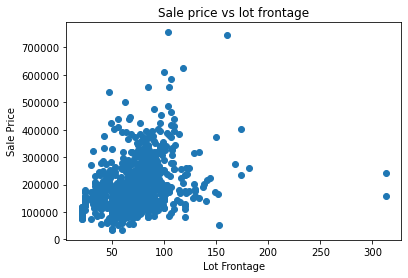

In [140]:
#Lot frontage might affect pricing, lets visualize the change of price with respect to frontage area to decide if these values should be imputed or dropped
plt.scatter(df_train['LotFrontage'],df_train['SalePrice'])
plt.xlabel("Lot Frontage")
plt.ylabel("Sale Price")
plt.title("Sale price vs lot frontage")

In [141]:
#From the above we can see that there seems to be a positive correlation between price and lot frontage. To verify this the correaletion matrix can be plotted
corr = df_train.loc[:,['LotFrontage','SalePrice']].corr()

Text(0.5, 1.0, 'Correleation between lot frontage and price')

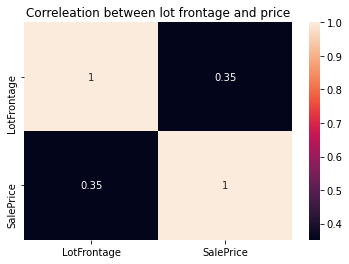

In [142]:
sns.heatmap(corr,annot=True)
plt.title("Correleation between lot frontage and price")

Text(0.5, 1.0, 'Lot Area vs lot frontage')

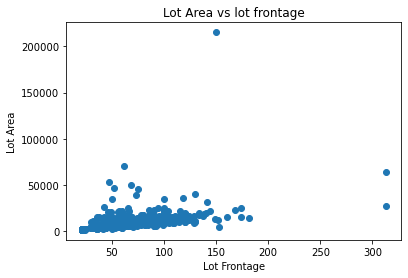

In [143]:
plt.scatter(df_train['LotFrontage'],df_train['LotArea'])
plt.xlabel("Lot Frontage")
plt.ylabel("Lot Area")
plt.title("Lot Area vs lot frontage")

In [144]:
#Since the lot area and frontage area seem to have good cooreletion, the values of frontage can be calulcated by linear regression
df_area = df_train.dropna(axis=0,subset=['LotArea','LotFrontage']).loc[:,['LotArea','LotFrontage']]

In [145]:
# We need to extract our missing values and corresponding lot area values
missing_frontage = df_train['LotFrontage'].isnull()
area_frontage = pd.DataFrame(df_train['LotArea'][missing_frontage])

In [146]:
missing_index = list(area_frontage.index)

In [147]:
X = df_area[['LotArea']]
y = df_area['LotFrontage']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.2)

lm = LinearRegression().fit(X_train,y_train)

In [148]:
y_pred = lm.predict(X_test)
mean_squared_error(y_test,y_pred,squared=False)

33.96530666585377

In [149]:
#These values still have some error but are more accurate than imputing with mean or median
frontage_values = pd.DataFrame(lm.predict(area_frontage))

In [150]:
frontage_values.index = missing_index

In [151]:
df_train['LotFrontage'] = df_train['LotFrontage'].fillna(frontage_values[0])

In [152]:
df_train.loc[:,df_train.columns[df_train.isnull().any()]].isna().sum()

MasVnrType       8
MasVnrArea       8
BsmtQual        37
BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtFinType2    38
Electrical       1
GarageType      81
GarageYrBlt     81
GarageFinish    81
GarageQual      81
GarageCond      81
dtype: int64

In [153]:
#Na values for basement and garage imply there is no basement and no garage.These are important and filled with a string "No"
fill_columns = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','GarageType','GarageFinish','GarageQual','GarageCond']
df_train[fill_columns] = df_train[fill_columns].fillna("No")

In [154]:
df_train.loc[:,df_train.columns[df_train.isnull().any()]].isna().sum()

MasVnrType      8
MasVnrArea      8
Electrical      1
GarageYrBlt    81
dtype: int64

In [119]:
#The remaining missing values are really small and can these records can be removed from the dataset
df_train.dropna(inplace=True)
df_train.shape

(1451, 76)

In [129]:
df_train.loc[:,df_train.dtypes == "object"]

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,KitchenQual,Functional,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,Attchd,2003.0,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,TA,Typ,Attchd,1976.0,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,Attchd,2001.0,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,Gd,Typ,Detchd,1998.0,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,Gd,Typ,Attchd,2000.0,RFn,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,TA,Typ,Attchd,1999.0,RFn,TA,TA,Y,WD,Normal
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,...,TA,Min1,Attchd,1978.0,Unf,TA,TA,Y,WD,Normal
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,...,Gd,Typ,Attchd,1941.0,RFn,TA,TA,Y,WD,Normal
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,Gd,Typ,Attchd,1950.0,Unf,TA,TA,Y,WD,Normal


In [123]:
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.00000,1451.000000,...,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000
mean,729.374225,56.933150,71.592190,10507.808408,6.093728,5.579600,1971.092350,1984.760165,103.75672,442.274983,...,94.412819,46.422467,21.952447,3.430737,15.154376,2.776017,43.758787,6.319090,2007.815300,180624.101999
std,421.737858,42.350366,28.326817,9992.987081,1.381467,1.113415,30.190266,20.651334,181.10815,455.369276,...,125.436852,66.060150,61.108223,29.406940,55.917522,40.301212,497.648467,2.700353,1.329376,79312.128273
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,364.500000,20.000000,60.000000,7537.500000,5.000000,5.000000,1954.000000,1966.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129900.000000
50%,729.000000,50.000000,70.000000,9477.000000,6.000000,5.000000,1972.000000,1993.000000,0.00000,381.000000,...,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,1094.500000,70.000000,80.000000,11600.000000,7.000000,6.000000,2000.000000,2004.000000,166.00000,707.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,467.202512,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.00000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## Data Preperation for model fitting

In [ ]:
#The dataset has 37 numerical columns and 39 categorical columns
